# Image classification using convolutional neural networks

## Introduction - the dataset

Image classification has historically been one of the most challenging tasks in computer vision.
Convolutional neural networks (CNN) have allowed an unprecedented improvement in the accuracy of image classification.

For this workshop we will use a modified version of the [ISIC 2020 Challenge dataset](https://challenge2020.isic-archive.com/). The original version of this dataset contains 33126 images benign and malignant skin lesions from over 2000 patients. The dataset is particularly challenging to work with (well, it's from a challenge, after all!) because of the very imbalanced training dataset, which contains only less than 600 images of malignant lesions.

To simplify matters, and allow you to run this in a reasonable time frame, I have created a balanced version of the dataset, with 584 benign and 584 malignant images. Images in the original dataset are quite large (some are up to 4000 x 6000 pixels) and of different size; for simplicity I have resized them to 500 x 500 which should be sufficient for this workshop.

Finally, note that all of the images used in this workshop come from the training set of the challenge. This is so that we have the ground truth for each image (which is obviously unavailable for the test set in the original data).

## Learning objectives

At the end of this workshop you should be able to

- Create a CNN classifier using Keras
- Use regularization to avoid overfitting
- Use data augmentation to avoid overfitting and improve accuracy

We start by importing our _usual_ libraries, such as keras, matplotlib numpy and pandas.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

2024-10-22 10:19:30.782437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Make sure you have the `ISIC2020_Small_metadata.csv` and `ISIC2020_Small.zip` files in the same directory as this notebook. Unzip the `ISIC2020_Small.zip` into a folder called "ISIC2020_Small" in the same directory as this notebook.

The `ISIC2020_Small_metadata.csv` file contains information about all the images in the dataset. Let's open it and see what we find.

Use the `value_counts` function to count the number of images in each class (benign vs malignant). 

How many are coming from men and how many from women?

<details>
<summary style="cursor: pointer;">Click here to reveal a hint.</summary>
Try using

<code>
metadata['column_name'].value_counts()
</code>

You can even pass a list of columns instead of a single string!
</details>

In [2]:
image_dir = 'ISIC2020_Small/'
metadata = pd.read_csv('ISIC2020_Small_metadata.csv')
print(metadata.head())

print(metadata['benign_malignant'].value_counts())
print(metadata['sex'].value_counts())
print(metadata[['sex', 'benign_malignant']].value_counts())

     image_name  patient_id   lesion_id     sex  age_approx  \
0  ISIC_2988993  IP_1705144  IL_8255250  female        50.0   
1  ISIC_6498256  IP_7104534  IL_3276458  female        50.0   
2  ISIC_8526513  IP_0892152  IL_6379048    male        50.0   
3  ISIC_3111722  IP_8663649  IL_1170755    male        45.0   
4  ISIC_3624807  IP_8330575  IL_3683690    male        50.0   

  anatom_site_general_challenge diagnosis benign_malignant  target  
0                         torso     nevus           benign       0  
1               lower extremity   unknown           benign       0  
2                         torso   unknown           benign       0  
3                         torso   unknown           benign       0  
4                         torso   unknown           benign       0  
benign       584
malignant    584
Name: benign_malignant, dtype: int64
male      662
female    506
Name: sex, dtype: int64
sex     benign_malignant
male    malignant           364
        benign             

Because this is a very small dataset, it will easily fit into memory, so we could read all images.

This can quickly become unmanageable for larger datasets, though, but luckily Keras has a built-in function to help with this.

We are going to use the [keras.preprocessing.image_dataset_from_directory](https://keras.io/api/preprocessing/image/) function to create an image generator that will pull images when needed.

The function can infer labels directly from the subdirectory names, which makes life a lot easier!

We can also provide a batch size, which is the number of images we want to load at once. We can set it to 64, which should be easy enough to handle, but you might want to experiment with that.

Note that we call the same function twice, once for the training set and once for the validation set. We use the `validation_split` parameter to split the dataset into training and validation sets (80% and 20%, respectively) and, **very importantly**, we set the `seed` parameter to the same number (you can use any number you like) to ensure that the same images are used for training and validation in both cases! This also ensures reproducibility.

In [7]:
from keras.utils import image_dataset_from_directory

training_dataset = image_dataset_from_directory(
    image_dir, 
    labels="inferred",   
    batch_size = 64,
    subset='training',
    validation_split=0.2,
    seed=12345)

test_dataset = image_dataset_from_directory(
    image_dir,
    labels="inferred",
    batch_size = 64,
    subset='validation',
    validation_split=0.2,
    seed=12345) 

Found 1168 files belonging to 2 classes.


Using 935 files for training.
Found 1168 files belonging to 2 classes.
Using 233 files for validation.


In [19]:
batch = training_dataset.take(1)
images, labels = next(iter(batch))

(64, 256, 256, 3)


2024-10-22 10:24:20.136440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [935]
	 [[{{node Placeholder/_4}}]]
2024-10-22 10:24:20.136714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [935]
	 [[{{node Placeholder/_0}}]]


We can now use the `take` method of the generator to load some images for display.
We can pass 1 to `take` to get a single batch of images, then iterate through them.

`take` returns a TensorFlow dataset, which is an iterable object, so we can use a for loop to iterate through it.

Alternatively using

`next(iter(training_dataset))` will return the next batch of (images, labels) from the dataset.

Note that the images are returned as TensorFlow tensors, which are not directly displayable (but are very efficient for training!). We can use the `numpy()` method to convert them to numpy arrays, which can be displayed using `matplotlib`.

<details>
<summary style="cursor: pointer;">Click here to reveal a hint.</summary>
Try using

```
# Note this returns *the whole batch*
for images, labels in training_dataset.take(1): 
    for im in images:
        ...
    <display images>

```

You can even pass a list of columns instead of a single string!
</details>

2024-10-22 11:05:27.761644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [935]
	 [[{{node Placeholder/_4}}]]
2024-10-22 11:05:27.761830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [935]
	 [[{{node Placeholder/_4}}]]


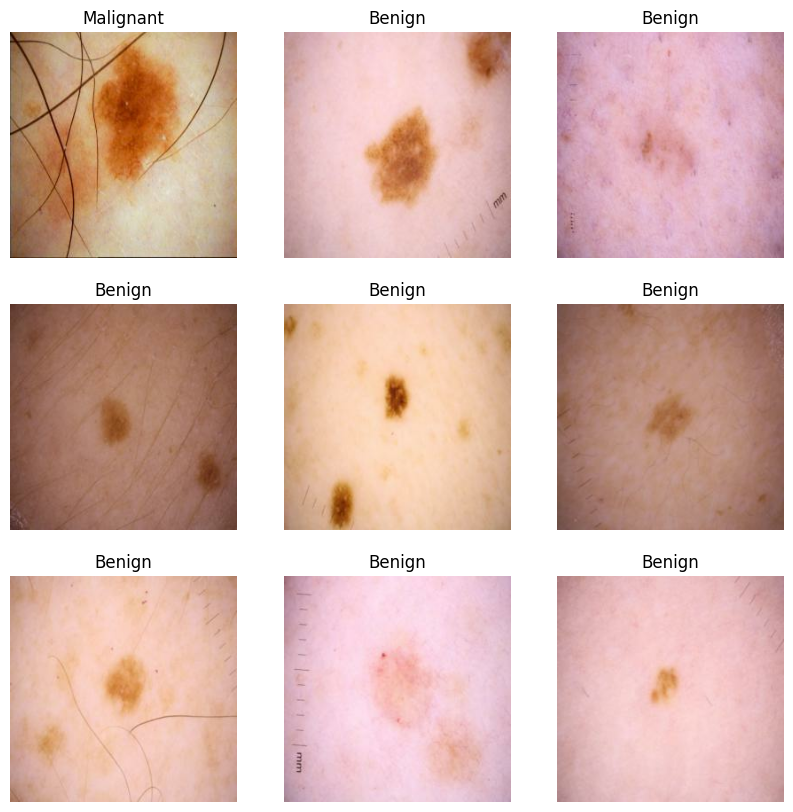

In [34]:
# Display the first 9 images
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10)) 

classes = ['Benign', 'Malignant']

# Take a batch from the dataset
img_batch = training_dataset.take(1)

# Iterate through the batch and unpack images and labels
for images, labels in img_batch:
    for i in range(9):
        ax.flat[i].imshow(images[i].numpy().astype('uint8'))
        ax.flat[i].axis('off')
        ax.flat[i].set_title(classes[labels[i]])


Ok, we have our images and labels. Let's create a model!

Create a convolutional neural network (CNN) model with the following architecture:

- 3 modules of 3x3 convolutional layers with 32, 64, and 128 filters respectively followed by a max pooling layer
- 2 dense layers with 512 and 64 units respectively
- a final dense layer with 1 unit for the output

Use ReLU activation for all layers except the last one where you can use a sigmoid.

Compile the model. 

**What optimizer and loss function do you want to use?**
**What metrics do you want to calculate?**

We will use the Adam optimizer (but you can experiment with others!) and the binary crossentropy loss function, since we are trying to classify between two classes. Note that we could use the categorical crossentropy loss function, but we would need a final dense layer with 2 nodes and a softmax activation.

Since this is a binary classification problem, we will use the accuracy metric.

In [35]:
model = keras.models.Sequential()

model.add(keras.layers.InputLayer((256, 256, 3)))

model.add(keras.layers.Conv2D(filters = 32, 
          kernel_size=3, 
          padding="same", 
          activation = "relu"))

model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters = 64, 
          kernel_size=(3,3), 
          padding="same", 
          activation = "relu"))

model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters = 128, 
          kernel_size=(3,3),
          padding="same", 
          activation = "relu"))

model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

# Flatten the nodes and add a fully connected network at the end
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units = 512, activation = "relu"))
model.add(keras.layers.Dense(units = 64, activation = "relu"))
# Finally, we have only one node as we are doing a binary prediction
model.add(keras.layers.Dense(units = 1, activation = "sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

We can now proceed to train our model. We will train for 50 epochs, with a batch size of 128. 

So, every epoch all of the training images are used to train the network, 128 images at a time.

Note that we use our test set for validation, so we have no proper validation set for this example.

The `train` function returns the model's history, which contains information about the accuracy over training. This is important to check how well the model is working.

Since this is a fairly time-consuming process, you might want to run this on [Google Colab](https://colab.research.google.com/) or on [Kaggle](https://www.kaggle.com/), using a GPU.

In [37]:
batch_size = 128
epochs_num = 50
# THIS TAKES A VERY LONG TIME!
res = model.fit(training_dataset, 
                validation_data=test_dataset, 
                batch_size = batch_size, 
                epochs = epochs_num, 
                verbose = 1) 

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 356.8636 - accuracy: 0.5348

2024-10-22 11:08:19.758819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [233]
	 [[{{node Placeholder/_4}}]]
2024-10-22 11:08:19.759088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [233]
	 [[{{node Placeholder/_4}}]]


15/15 [==============================] - 3s 165ms/step - loss: 356.8636 - accuracy: 0.5348 - val_loss: 0.9783 - val_accuracy: 0.4893
Epoch 2/50
15/15 [==============================] - 1s 69ms/step - loss: 0.6689 - accuracy: 0.6289 - val_loss: 0.6443 - val_accuracy: 0.6910
Epoch 3/50
15/15 [==============================] - 1s 69ms/step - loss: 0.6220 - accuracy: 0.6695 - val_loss: 0.6403 - val_accuracy: 0.6438
Epoch 4/50
15/15 [==============================] - 1s 68ms/step - loss: 0.6051 - accuracy: 0.7005 - val_loss: 0.5987 - val_accuracy: 0.6781
Epoch 5/50
15/15 [==============================] - 1s 68ms/step - loss: 0.5637 - accuracy: 0.7123 - val_loss: 0.5704 - val_accuracy: 0.7082
Epoch 6/50
15/15 [==============================] - 1s 70ms/step - loss: 0.9559 - accuracy: 0.7059 - val_loss: 0.6128 - val_accuracy: 0.7339
Epoch 7/50
15/15 [==============================] - 1s 69ms/step - loss: 0.5546 - accuracy: 0.7305 - val_loss: 0.5781 - val_accuracy: 0.7339
Epoch 8/50
15/15 [===

We can now plot loss and accuracy for our model.

**What can you tell from the plot?** (you might want to zoom in on the y axis)

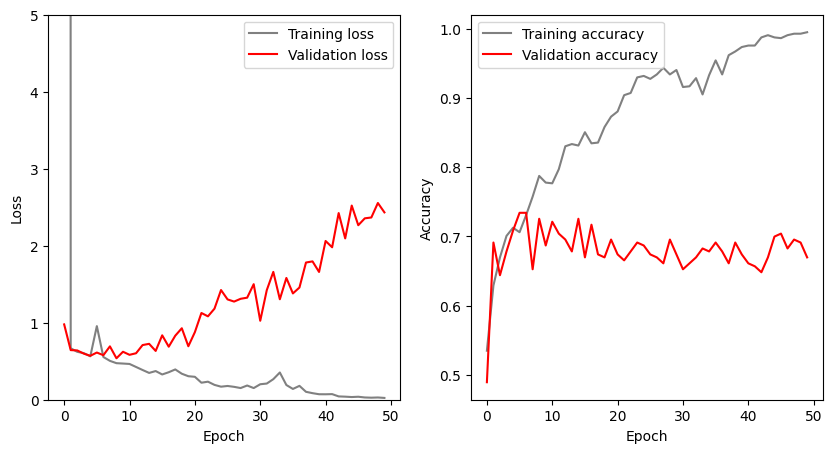

In [39]:
_, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

ax[0].plot(res.history['loss'], c='gray', label = "Training loss")
ax[0].plot(res.history['val_loss'], c='red', label = "Validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_ylim(0, 5)
ax[0].legend()

ax[1].plot(res.history['accuracy'], c='gray', label="Training accuracy")
ax[1].plot(res.history['val_accuracy'], c='red', label = "Validation accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show()

Optionally, you can save the model for later use, so you don't have to train it again.

In [41]:
model.save("mymodels/melanoma_model_01")
# You can load back the model at any time using
# model = keras.models.load_model('mymodels/melanoma_model_01)

INFO:tensorflow:Assets written to: mymodels/melanoma_model_01/assets


INFO:tensorflow:Assets written to: mymodels/melanoma_model_01/assets


We have slightly more than 75% accuracy, which is OK, but can definitely be improved!

What do you think is happening here?

<details>
<summary style="cursor: pointer;">Click here to reveal the solution.</summary>
Our model seems to be **overfitting**! 
**How do we tell that?**

1. The loss continues to decrease, but validation loss goes up
2. Training accuracy goes up, but validation reaches a plateau
</details>

There are several things that we can improve.

1. We can regularize the model by adding **dropout**. This would be especially important for the dense layers.

2. We can add regularization (e.g. **L2 regularization**) to the model

3. Part of the issue is that the training set is somewhat limited. This is partly because I have given you only a small amount of images, however keep in mind that having a very large amount of image data is not always a given, actually it is quite uncommon! 
As we saw in the lectures, we can use **data augmentation** to increase the size of our dataset.

Let's train a new model exactly in the same way, but adding dropout and regularization.

1. Add 40% Dropout layers after each Dense layer (not the last one, obviously!)
2. Add L2 regularization to the Conv2D layers

In [42]:
model2 = keras.models.Sequential()

model2.add(keras.layers.InputLayer(input_shape=(256, 256, 3)))

model2.add(keras.layers.Conv2D(filters = 32, 
          kernel_size=3, 
          padding="same", 
          activation = "relu",
          kernel_regularizer="l2"))

model2.add(keras.layers.MaxPool2D(pool_size=(2,2)))

model2.add(keras.layers.Conv2D(filters = 64, 
          kernel_size=(3,3), 
          padding="same", 
          activation = "relu",
          kernel_regularizer="l2"))

model2.add(keras.layers.MaxPool2D(pool_size=(2,2)))

model2.add(keras.layers.Conv2D(filters = 128, 
          kernel_size=(3,3),
          padding="same", 
          activation = "relu",
          kernel_regularizer="l2"))

model2.add(keras.layers.MaxPool2D(pool_size=(2,2)))

# Flatten the nodes and add a fully connected network at the end
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(units = 512, activation = "relu", kernel_regularizer="l2"))
model2.add(keras.layers.Dropout(0.4))
model2.add(keras.layers.Dense(units = 64, activation = "relu", kernel_regularizer="l2"))
model2.add(keras.layers.Dropout(0.4))
# Finally, we have only one node as we are doing a binary prediction
model2.add(keras.layers.Dense(units = 1, activation = "sigmoid"))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)     

As before, repeat the training

In [43]:
batch_size = 128
epochs_num = 50

res2 = model2.fit(training_dataset, 
                validation_data=test_dataset, 
                batch_size = batch_size, 
                epochs = epochs_num, 
                verbose = 1) 

# Save model
model2.save("mymodels/melanoma_02")
# You can also save the history!
np.save('mymodels/melanoma_02_history.npy', res2.history)

Epoch 1/50
15/15 [==============================] - 2s 78ms/step - loss: 143.8103 - accuracy: 0.4963 - val_loss: 14.9192 - val_accuracy: 0.5966
Epoch 2/50
15/15 [==============================] - 1s 72ms/step - loss: 15.7621 - accuracy: 0.5904 - val_loss: 16.1085 - val_accuracy: 0.5536
Epoch 3/50
15/15 [==============================] - 1s 73ms/step - loss: 15.8856 - accuracy: 0.5209 - val_loss: 15.2999 - val_accuracy: 0.5150
Epoch 4/50
15/15 [==============================] - 1s 73ms/step - loss: 14.9095 - accuracy: 0.5401 - val_loss: 14.2062 - val_accuracy: 0.5665
Epoch 5/50
15/15 [==============================] - 1s 74ms/step - loss: 13.7316 - accuracy: 0.6267 - val_loss: 13.1570 - val_accuracy: 0.6910
Epoch 6/50
15/15 [==============================] - 1s 72ms/step - loss: 13.1979 - accuracy: 0.5626 - val_loss: 12.4205 - val_accuracy: 0.5193
Epoch 7/50
15/15 [==============================] - 1s 75ms/step - loss: 12.0850 - accuracy: 0.5829 - val_loss: 11.6763 - val_accuracy: 0.643

2024-10-22 11:10:36.165050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2024-10-22 11:10:36.173129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2024-10-22 11:10:36.365371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2024-10-22 11:10:

INFO:tensorflow:Assets written to: mymodels/melanoma_02/assets


INFO:tensorflow:Assets written to: mymodels/melanoma_02/assets


Plot the loss and accuracy for the regularised model

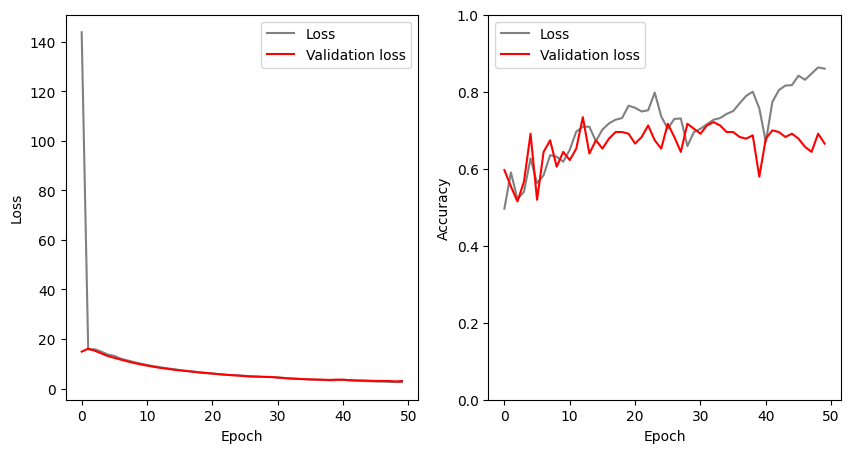

In [45]:
_, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

ax[0].plot(res2.history['loss'], c='gray', label = "Loss")
ax[0].plot(res2.history['val_loss'], c='red', label = "Validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(res2.history['accuracy'], c='gray', label="Loss")
ax[1].plot(res2.history['val_accuracy'], c='red', label = "Validation loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim(0, 1)
ax[1].legend()

Now, that's much better!

The model is now regularised, so it does not overfit anymore (or not as badly). You can play with the hyperparameters to see if you can improve the model even further.

Finally, we can use the model to predict the class of some images. We are going to use the validation set for this, although it would be better to have a separate test set.

In [46]:
from sklearn.metrics import confusion_matrix

images, labels = next(iter(test_dataset))

predictions = model2.predict(images)
predictions = [1 if x > 0.5 else 0 for x in predictions]

confusion_matrix(labels, predictions)

2/2 [==============================] - 0s 10ms/step


array([[27,  6],
       [17, 14]])

How did your model do? Can you improve it further?


And that is the end of worshop 6! Hope you enjoyed it and keep (deep) learning!